# Introduction to MTLnet

Welcome! This jupyter notebook carries out core analyses and visualizations for exploring functional and structural network connectivity in the medial temporal lobe (MTL). We have provide a sample dataset, and our methods can be applied to your own datasets of healthy or diseased subjects. Input data includes time series from 7T resting state BOLD-fMRI as well as volumetric data derived from 7T T2-weighted MRI. Note: metrics derived from bootstrapped data may vary slightly each time the pipeline is run due to randomization in bootstrapping.

This serves as a supplement to our paper in submission at Human Brain Mapping [link to be included upon publication of paper]. Please see paper for details on image acquisition, processing, and analysis.

MTL segmentation was carried out using the ASHS pipeline (https://sites.google.com/site/hipposubfields/) 

# 1. Setup

Here we import some key modules and define our MTL labels. We have defined 10 subregions per hemisphere as follows:

<strong>Hippocampal subfields: </strong> CA1, CA2, CA3, DG (dentate gyrus), SUB (subiculum), TAIL (posterior-most aspects of hippocampus)

<strong> Extra-hippocampal cortical regions </strong>: ERC (entorhinal cortex), PHC (parahippocampal cortex), BA35 and BA36 (Brodmann areas, part of the perirhinal corex)

*CA=cornu ammonis

In [252]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import bct
import ncat
import seaborn as sb
import itertools
import copy

from scipy.stats import linregress  
from tabulate import tabulate
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',
       r'\sansmath'
]

%matplotlib inline

sb.set(context="poster", font_scale=0.9)
mycmap=sb.cubehelix_palette(start=2.8,rot=0.05,as_cmap=True)

MTlabels = ['LCA1','LCA2','LDG', 'LCA3', 'LTAIL', 'LSUB', 'LERC','LBA35','LBA36','LPHC',
            'RCA1','RCA2','RDG', 'RCA3', 'RTAIL', 'RSUB', 'RERC', 'RBA35','RBA36','RPHC']
MTlabelshalf= ['CA1','CA2','DG', 'CA3', 'TAIL', 'SUB', 'ERC','BA35','BA36','PHC']
N=len(MTlabelshalf)

# 2. Function Definitions

Here we define key functions which will be used to generate the networks and carry out network analyses:

In [279]:
def null_rand(thismat):
    """
    generates a random matrix which preserves strength distribution by permuting entries in upper triangular matrix
    """
    
    dummy = np.triu(np.ones(np.shape(thismat)), 1) 
    full_upper = thismat[dummy == 1]
    ind = np.random.permutation(range(np.size(full_upper)))
    full_upper_perm= full_upper[ind]
    full_perm = dummy
    full_perm[dummy == 1] = full_upper_perm
    full_perm = full_perm + np.transpose(full_perm)
    return full_perm

def fisher(mymat):
    """
    fisher r to z transform on a matrix mymat
    """
    z = 0.5*np.log((1+mymat)/(1-mymat))
    return z

def makestructmat(structure):
    """
    generates structural covariance matrix given gray matter volumes in a group of subjects
    """
    structmat_tmp = np.corrcoef(structure)
    np.fill_diagonal(structmat_tmp, 0)
    structmat = fisher(structmat_tmp)     
    return structmat

def show_modules(mat, partitions, labels, colormap):
    """
    displays modular organization given a matrix and its partitions into modules
    """
    bounds, ixes = bct.grid_communities(np.array(map(int,partitions.T)))
    reorderedlabels = [ labels[i] for i in ixes]

    ax = sb.heatmap(mat[np.ix_(ixes,ixes)], square=True,xticklabels=reorderedlabels,
                                 yticklabels=reorderedlabels, cmap=colormap)
    for i in range(1,len(bounds)-1):

        ax.axvline(x=bounds[i]+0.5,color='red',ymin=1-(0.5+bounds[i-1])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]))
        ax.axvline(x=bounds[i]+0.5,color='red',ymin=1-(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[i+1])/(0.5+bounds[len(bounds)-1]))
        ax.axhline(19.5-bounds[i],color='red',xmin=(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[i+1])/(0.5+bounds[len(bounds)-1]))
        ax.axhline(19.5-bounds[i],color='red',xmin=(0.5+bounds[i-1])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[i])/(0.5+bounds[len(bounds)-1]))

    ax.axvline(x=bounds[0]+0.5,color='red',ymin=1-(0.5+bounds[0])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[1])/(0.5+bounds[len(bounds)-1]))
    ax.axhline(bounds[len(bounds)-1]-bounds[0],color='red',xmin=(0.5+bounds[0])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[1])/(0.5+bounds[len(bounds)-1]))

    ax.axvline(x=bounds[len(bounds)-1]+0.5,color='red',ymin=1-(0.5+bounds[len(bounds)-2])/(0.5+bounds[len(bounds)-1]),ymax=1-(0.5+bounds[len(bounds)-1])/(0.5+bounds[len(bounds)-1]))
    ax.axhline(bounds[len(bounds)-1]-bounds[len(bounds)-1],color='red',xmin=(0.5+bounds[len(bounds)-2])/(0.5+bounds[len(bounds)-1]),xmax=(0.5+bounds[len(bounds)-1])/(0.5+bounds[len(bounds)-1]))


def sig_mods(nperms, mymat, Q, gamma ):
    """
    determines sigificance of modular organization using permutation testing
    """
    Q_null = np.zeros((nperms))
    for i in range(0, nperms):
        nullmat = null_rand(mymat)
        S_null, Q_null[i] = bct.community_louvain(nullmat,gamma)
    p = np.sum(Q_null > Q) / float(mod_iters)
    return p


def struct_bootmats(structure, nboots):
    """
    generates bootstrapped structural matrices
    """
    nsubs = np.shape(structure)[1]   
    nROIs = np.shape(structure)[0]     
    boot_structmats = np.zeros((nROIs,nROIs,nboots)) 
    for i in range(0, nboots):
        boot_idx = np.random.randint(0,nsubs, nsubs)
        boot_structure = structure[0:nROIs,boot_idx]
        boot_structmat = makestructmat(boot_structure)
        boot_structmat[boot_structmat < 0] = 0
        boot_structmats[:,:,i] = boot_structmat  
    return boot_structmats

def func_bootmats(funcmats, nboots):    
    """
    generates bootstrapped functional matrices
    """   
    nsubs = np.shape(funcmats)[2]  
    nROIs = np.shape(funcmats)[0] 
    boot_funcmats = np.zeros((nROIs,nROIs,nboots))    
    for i in range(0, nboots):
        boot_idx = np.random.randint(0,nsubs, nsubs)
        boot_funcmats[:,:,i] = np.mean(funcmats[:,:,boot_idx],axis=2)   
    return boot_funcmats

def nodal_efficiency(mymat):
    """
    generates nodal efficiency based on equation in Achard & Bullmore, PLoS Comp Bio 2007
    """
    L =  bct.weight_conversion(mymat, 'lengths', copy=True)
    D,B = bct.distance_wei(L) 
    np.fill_diagonal(D, 1)
    invD = 1.0/D
    Li = np.sum(invD,axis=0)/(np.shape(D)[1] - 1) 
    return Li

def boot_metrics(boot_mats, metric):   
    """
    generates global and local network metrics from bootstrapped networks
    accepted metrics are "CS" (strength), "CC" (clustering coeff), or "LE" (efficiency)
    one can add additional metrics to this function as desired
    """
    nboots = np.shape(boot_mats)[2] 
    nROIs = np.shape(boot_mats)[0] 
    boot_metric_global = np.zeros((nboots))
    boot_metric_local = np.zeros((nboots, nROIs))
    
    if metric=="CS":
        for i in range(0, nboots):
            boot_metric_local[i,:] = bct.strengths_und(boot_mats[:,:,i])/float(nROIs)
            boot_metric_global[i] = np.mean(bct.strengths_und(boot_mats[:,:,i]))

    elif metric=="CC":
        for i in range(0, nboots):
            boot_metric_local[i,:] = bct.clustering_coef_wu(boot_mats[:,:,i])
            boot_metric_global[i] = np.mean(bct.clustering_coef_wu(boot_mats[:,:,i]))

    elif metric=="LE":
        for i in range(0, nboots):
            boot_metric_local[i,:] = nodal_efficiency(boot_mats[:,:,i])
            boot_metric_global[i] = bct.efficiency_wei(boot_mats[:,:,i])
    else:
        print "incorrect metric input - must be CS, CC, or LE"
  
    return boot_metric_global,boot_metric_local

# 3. Structural Network Generation

Here we generate the group-level structural covariance network from a group of 31 healthy subjects:

In [261]:
# Grab volumes from csv file
fname="../data/structural/all_volumes.csv"
structure = np.matrix(np.loadtxt(fname,delimiter=','))
volume = copy.deepcopy(structure)

# Normalize volumes by A-P extent in cortical regions
fname_extent = "../data/structural/all_extents.csv"
extent= np.matrix(np.loadtxt(fname_extent,delimiter=','))
ind_cortical = [6,7,8,9,16,17,18,19] # indices of cortical regions (bilateral ERC,BA35,BA36,PHC) to normalize by extent
structure[ind_cortical,:] = np.divide(structure[ind_cortical,:],extent[ind_cortical,:])

# Extract ICV (intracranial volume) data
fname_ICV = "../data/structural/all_ICV.csv"
ICV = np.matrix(np.loadtxt(fname_ICV,delimiter=','))

# Regress out ICV
slope = np.zeros((2*N))
for i in range(0, 2*N):
    slope[i], intercept, r_value, p_value, std_err = linregress(ICV,structure[i,:])
    structure[i,:] = structure[i,:] -slope[i]*(ICV -np.mean(ICV,axis=1))
structure = np.matrix(structure[0:2*N,:])

# Make structural matrix and threshold out negatives
structmat = makestructmat(structure)
structmat_nonzeroed = np.array(structmat)
structmat[structmat < 0] = 0

Let's plot the resulting adjacency matrix to visualize the resulting structural covariance network:

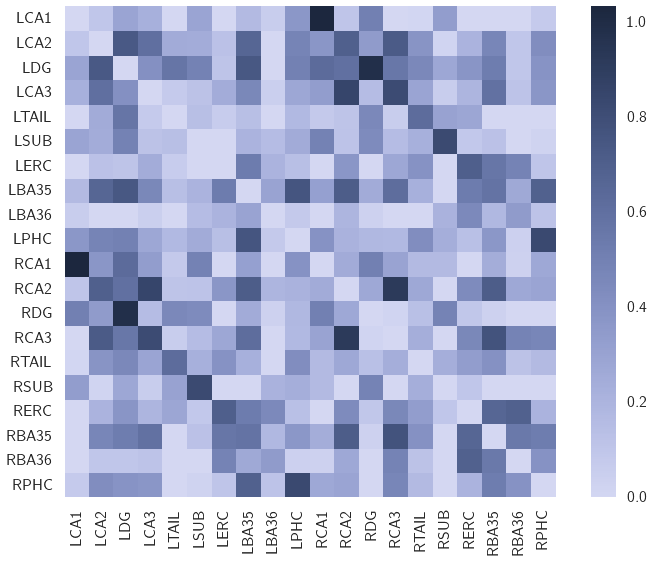

In [271]:
sb.heatmap(structmat, square=True,xticklabels=MTlabels, yticklabels=MTlabels, cmap=mycmap)

# 4. Functional Network Generation

Here we generate the group-level functional connectivity network from a group of 24 healthy subjects:

In [313]:
subject_names = ["CTL01_S2", "CTL03_S1","CTL04_S1","CTL05_S1","CTL06_S1","CTL07_S1","CTL08_S1","CTL09_S1","CTL10_S1",
                 "CTL11_S1", "CTL12_S1","CTL13_S1","CTL14_S1", "CTL15_S1", "YHC02", "YHC03","YHC05","YHC06","YHC09",
                 "YHC10","YHC14","YHC15","YHC20","YHC22"]

# Grab low-frequency rs-fmri time series from txt files
funcmats = np.zeros((len(MTlabels),len(MTlabels),len(subject_names)))
num_cols = 302
for idx, subject_name in enumerate(subject_names):
    
    # Left hemisphere    
    fname_L = "../data/functional/" + subject_name + "/res_tcourse_L.txt"
    with open(fname_L, 'r') as f:
        f.readline()
        f.seek(0)   
    Left_tcourse =np.matrix(np.loadtxt(fname_L, skiprows=1, usecols=range(1,num_cols)))  
    
    # Right hemisphere
    fname_R = "../data/functional/" + subject_name + "/res_tcourse_R.txt"
    with open(fname_R, 'r') as f:
        f.readline()
        f.seek(0)
    Right_tcourse = np.matrix(np.loadtxt(fname_R, skiprows=1, usecols=range(1,num_cols)))
     
    # Make functional matrix
    Bilat_tcourse = np.concatenate((Left_tcourse, Right_tcourse), axis=0)
    Bilat_tcourse = np.delete(Bilat_tcourse, [0,5,7,13,18,20],0) # exclude useless nodes (background, head, and miscellaneous labels)  
    mat = np.corrcoef(Bilat_tcourse)   
    np.fill_diagonal(mat, 0)    
    mat = fisher(mat) 
    funcmats[:,:,idx] = mat    

# Threshold out negatives and get group-level functional matrix
funcmats_nonzeroed = np.array(funcmats)
funcmats_nonzeroed_avg = np.mean(funcmats_nonzeroed,axis=2)
funcmats[funcmats < 0] =0
funcmat = np.mean(funcmats,axis=2)

Let's plot the resulting adjacency matrix to visualize the resulting functional connectivity network:

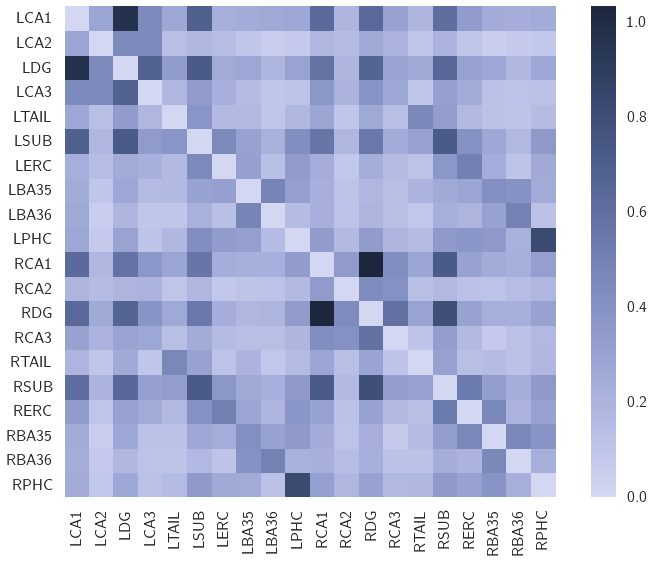

In [268]:
sb.heatmap(funcmat, square=True,xticklabels=MTlabels,yticklabels=MTlabels, cmap=mycmap)

# 5. Volumetric Analysis

Here, we compute and print out the volumes of each MTL subregion, as well as the whole hippocampus and whole MTL:

In [295]:
MTlabelshalf_plus= ['CA1','CA2','DG', 'CA3', 'TAIL', 'SUB', 'ERC','BA35','BA36','PHC','HIPP','MTL']
reordered = [0,1,3,2,4,5,6,7,8,9,10,11] #reorder subregions so it plots and prints table in a nice order

# Compute volumes:
volumes_plus = np.concatenate((volumes[0:N,:],np.sum(volumes[0:6,:],axis=0),
                                   np.sum(volumes[0:N,:],axis=0), volumes[N:2*N,:],
                                   np.sum(volumes[N:N+6,:],axis=0), np.sum(volumes[N:2*N,:],axis=0)),axis=0)
meanvols_plus = np.mean(volumes_plus,axis=1)
stdvols_plus = np.std(volumes_plus,axis=1)

# Output volume table:
meanvol_lr_plus = np.reshape(meanvols_plus, (N_plus, 2),order='F')
stdvol_lr_plus = np.reshape(stdvols_plus, (N_plus, 2),order='F')
voldata = np.array(np.concatenate((meanvol_lr_plus[:,0], stdvol_lr_plus[:,0], meanvol_lr_plus[:,1], stdvol_lr_plus[:,1]),axis=1)) 
voltable = voldata[reordered,:].tolist()
MTlabelshalf_reordered = [ MTlabelshalf_plus[i] for i in reordered ]
for i,row in enumerate(voltable):
    row.insert(0,MTlabelshalf_reordered[i])
header = ["Subregion", "L Vol Mean","L Vol SD","R Vol Mean","R Vol SD"]
print tabulate(voltable, header, tablefmt="fancy_grid",floatfmt=".4g")

╒═════════════╤══════════════╤════════════╤══════════════╤════════════╕
│ Subregion   │   L Vol Mean │   L Vol SD │   R Vol Mean │   R Vol SD │
╞═════════════╪══════════════╪════════════╪══════════════╪════════════╡
│ CA1         │       820.7  │    182.4   │       803.5  │     160    │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ CA2         │        26.21 │      8.692 │        30.38 │      11.28 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ CA3         │       107.1  │     18.69  │        88.86 │      26.31 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ DG          │       622.7  │    122.7   │       740.2  │     127.6  │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ TAIL        │       315.4  │     83.03  │       296    │      69.92 │
├─────────────┼──────────────┼────────────┼──────────────┼────────────┤
│ SUB         │       837.2  │     93.25  │       853.2  │      

Here, we visualize the subregion-level volumetric asymmetry:

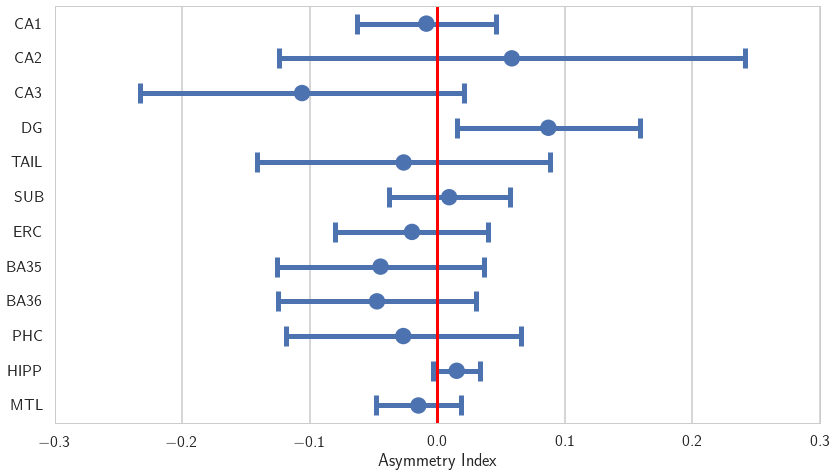

In [296]:
# Compute asymmetries (R- L / R + L):
N_plus=N+2
asymm= (volumes_plus[N_plus:2*N_plus,:] - volumes_plus[0:N_plus,:]) / (volumes_plus[N_plus:2*N_plus,:]+ volumes_plus[0:N_plus,:])
mean_asymm = np.mean(asymm,axis=1)
std_asymm = np.std(asymm,axis=1)

sb.set(context="poster", font_scale=1)
plt.figure(figsize=(12,7))
ts1=asymm[reordered,:]
ts2=[ MTlabelshalf_plus[i] for i in reordered ]
df = pd.DataFrame(data=ts1,index=ts2)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(mean_asymm[reordered]), [0,1,2,3,4,5,6,7,8,9,10,11], xerr=np.array(std_asymm[reordered]), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
plt.xlabel('Asymmetry Index')
plt.tight_layout()

# 6. Network Analysis

Now, we carry out network analyses on the structural and functional networks:

## 6.1 Network Hubness and Asymmetry

First, let's compute several key network metrics - namely connectivity strength, clustering coefficient, and local efficiency - for both structural and functional networks, using bootstrapping to obtain a measure of variability in the data. 

Note: this may take a while. To speed things up, decrease the number of bootstrapped samples (nboots).

In [276]:
nboots = 1000

In [280]:
# Structural Network Analyses
boot_structmats = struct_bootmats(structure, nboots)
CS_global, CS_local =boot_metrics(boot_structmats, "CS")
CC_global, CC_local =boot_metrics(boot_structmats, "CC")
LE_global, LE_local =boot_metrics(boot_structmats, "LE")

In [281]:
# Functional Network Analyses
boot_funcmats =func_bootmats(funcmats, nboots)
CS_globalf, CS_localf =boot_metrics(boot_funcmats, "CS")
CC_globalf, CC_localf =boot_metrics(boot_funcmats, "CC")
LE_globalf, LE_localf =boot_metrics(boot_funcmats, "LE")

In [283]:
# separate out by hemisphere for plotting purposes
sleftCS=CS_local[:,0:N]
srightCS=CS_local[:,N:2*N]
sleftCC=CC_local[:,0:N]
srightCC=CC_local[:,N:2*N]
sleftLE=LE_local[:,0:N]
srightLE=LE_local[:,N:2*N]

fleftCS=CS_localf[:,0:N]
frightCS=CS_localf[:,N:2*N]
fleftCC=CC_localf[:,0:N]
frightCC=CC_localf[:,N:2*N]
fleftLE=LE_localf[:,0:N]
frightLE=LE_localf[:,N:2*N]

Now, let's visualize the results. We can do this in two ways. First, let's plot the subregion-level metrics, along with asymmetries, for structural and functional networks. These are shown in 6.1.1 and 6.1.2 below:

### 6.1.1 Structural Network Subregion Metrics

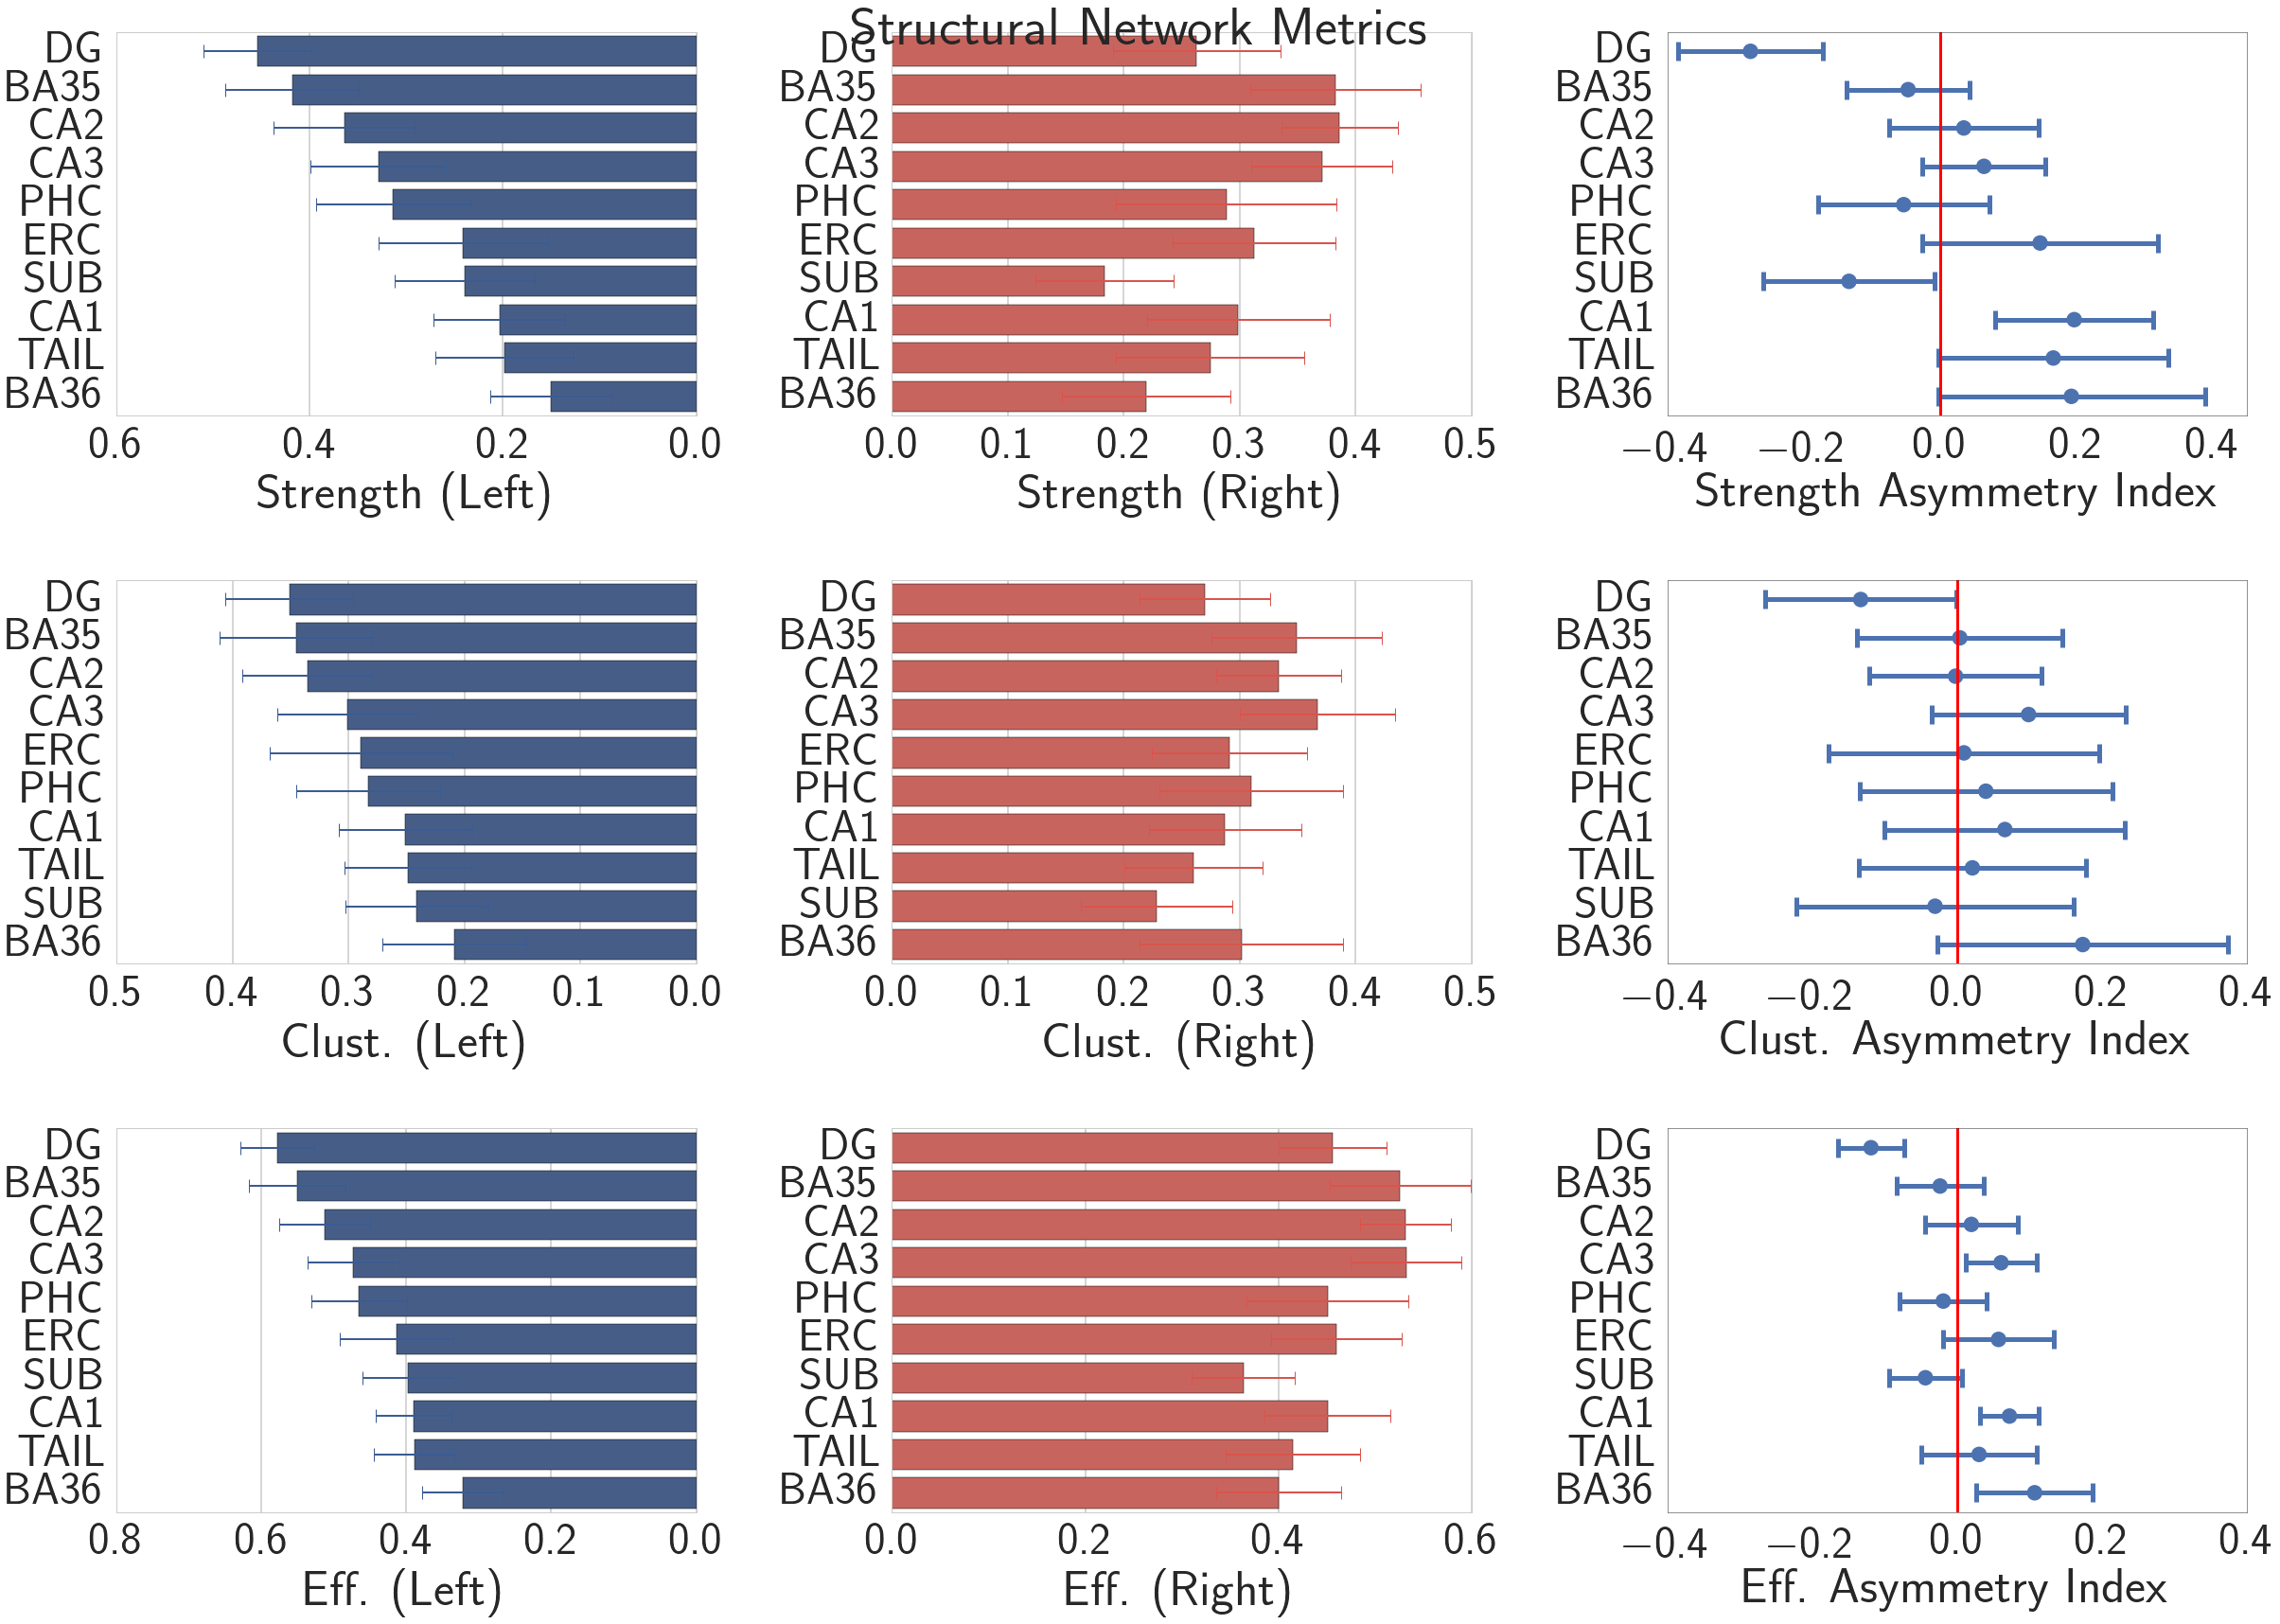

In [303]:
sb.set(context="poster", font_scale=3)
plt.figure(figsize=(35,25))
sb.set_style("whitegrid")
plt.suptitle("Structural Network Metrics")

# Left CS
left_strength_sortidx = np.argsort(np.mean(sleftCS,axis=0))[::-1]
left_sorted = sleftCS[:,left_strength_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_strength_sortidx]
plt.subplot(3, 3, 1)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Strength (Left)')

#Right CS
right_sorted = srightCS[:,left_strength_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_strength_sortidx]
plt.subplot(3, 3, 2)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Strength (Right)')

# CS Asymmetry
CS_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 3)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=CS_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(CS_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(CS_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.45])
plt.xlabel('Strength Asymmetry Index')

# Left CC
left_CC_sortidx = np.argsort(np.mean(sleftCC,axis=0))[::-1]
left_sorted = sleftCC[:,left_CC_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_CC_sortidx]
plt.subplot(3, 3, 4)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Clust. (Left)')

# Right CC
right_sorted = srightCC[:,left_CC_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_CC_sortidx]
plt.subplot(3, 3, 5)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Clust. (Right)')

# CC Asymmetry
CC_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 6)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=CC_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(CC_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(CC_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.4])
plt.xlabel('Clust. Asymmetry Index')

# Left LE
left_GE_sortidx = np.argsort(np.mean(sleftLE,axis=0))[::-1]
left_sorted = sleftLE[:,left_GE_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_GE_sortidx]
plt.subplot(3, 3, 7)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Eff. (Left)')

# Right LE
right_sorted = srightLE[:,left_GE_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_GE_sortidx]
plt.subplot(3, 3, 8)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Eff. (Right)')

# LE Asymmetry
GE_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 9)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=GE_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(GE_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(GE_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.4])

plt.xlabel('Eff. Asymmetry Index')
plt.tight_layout()


### 6.1.2 Functional Network Subregion Metrics

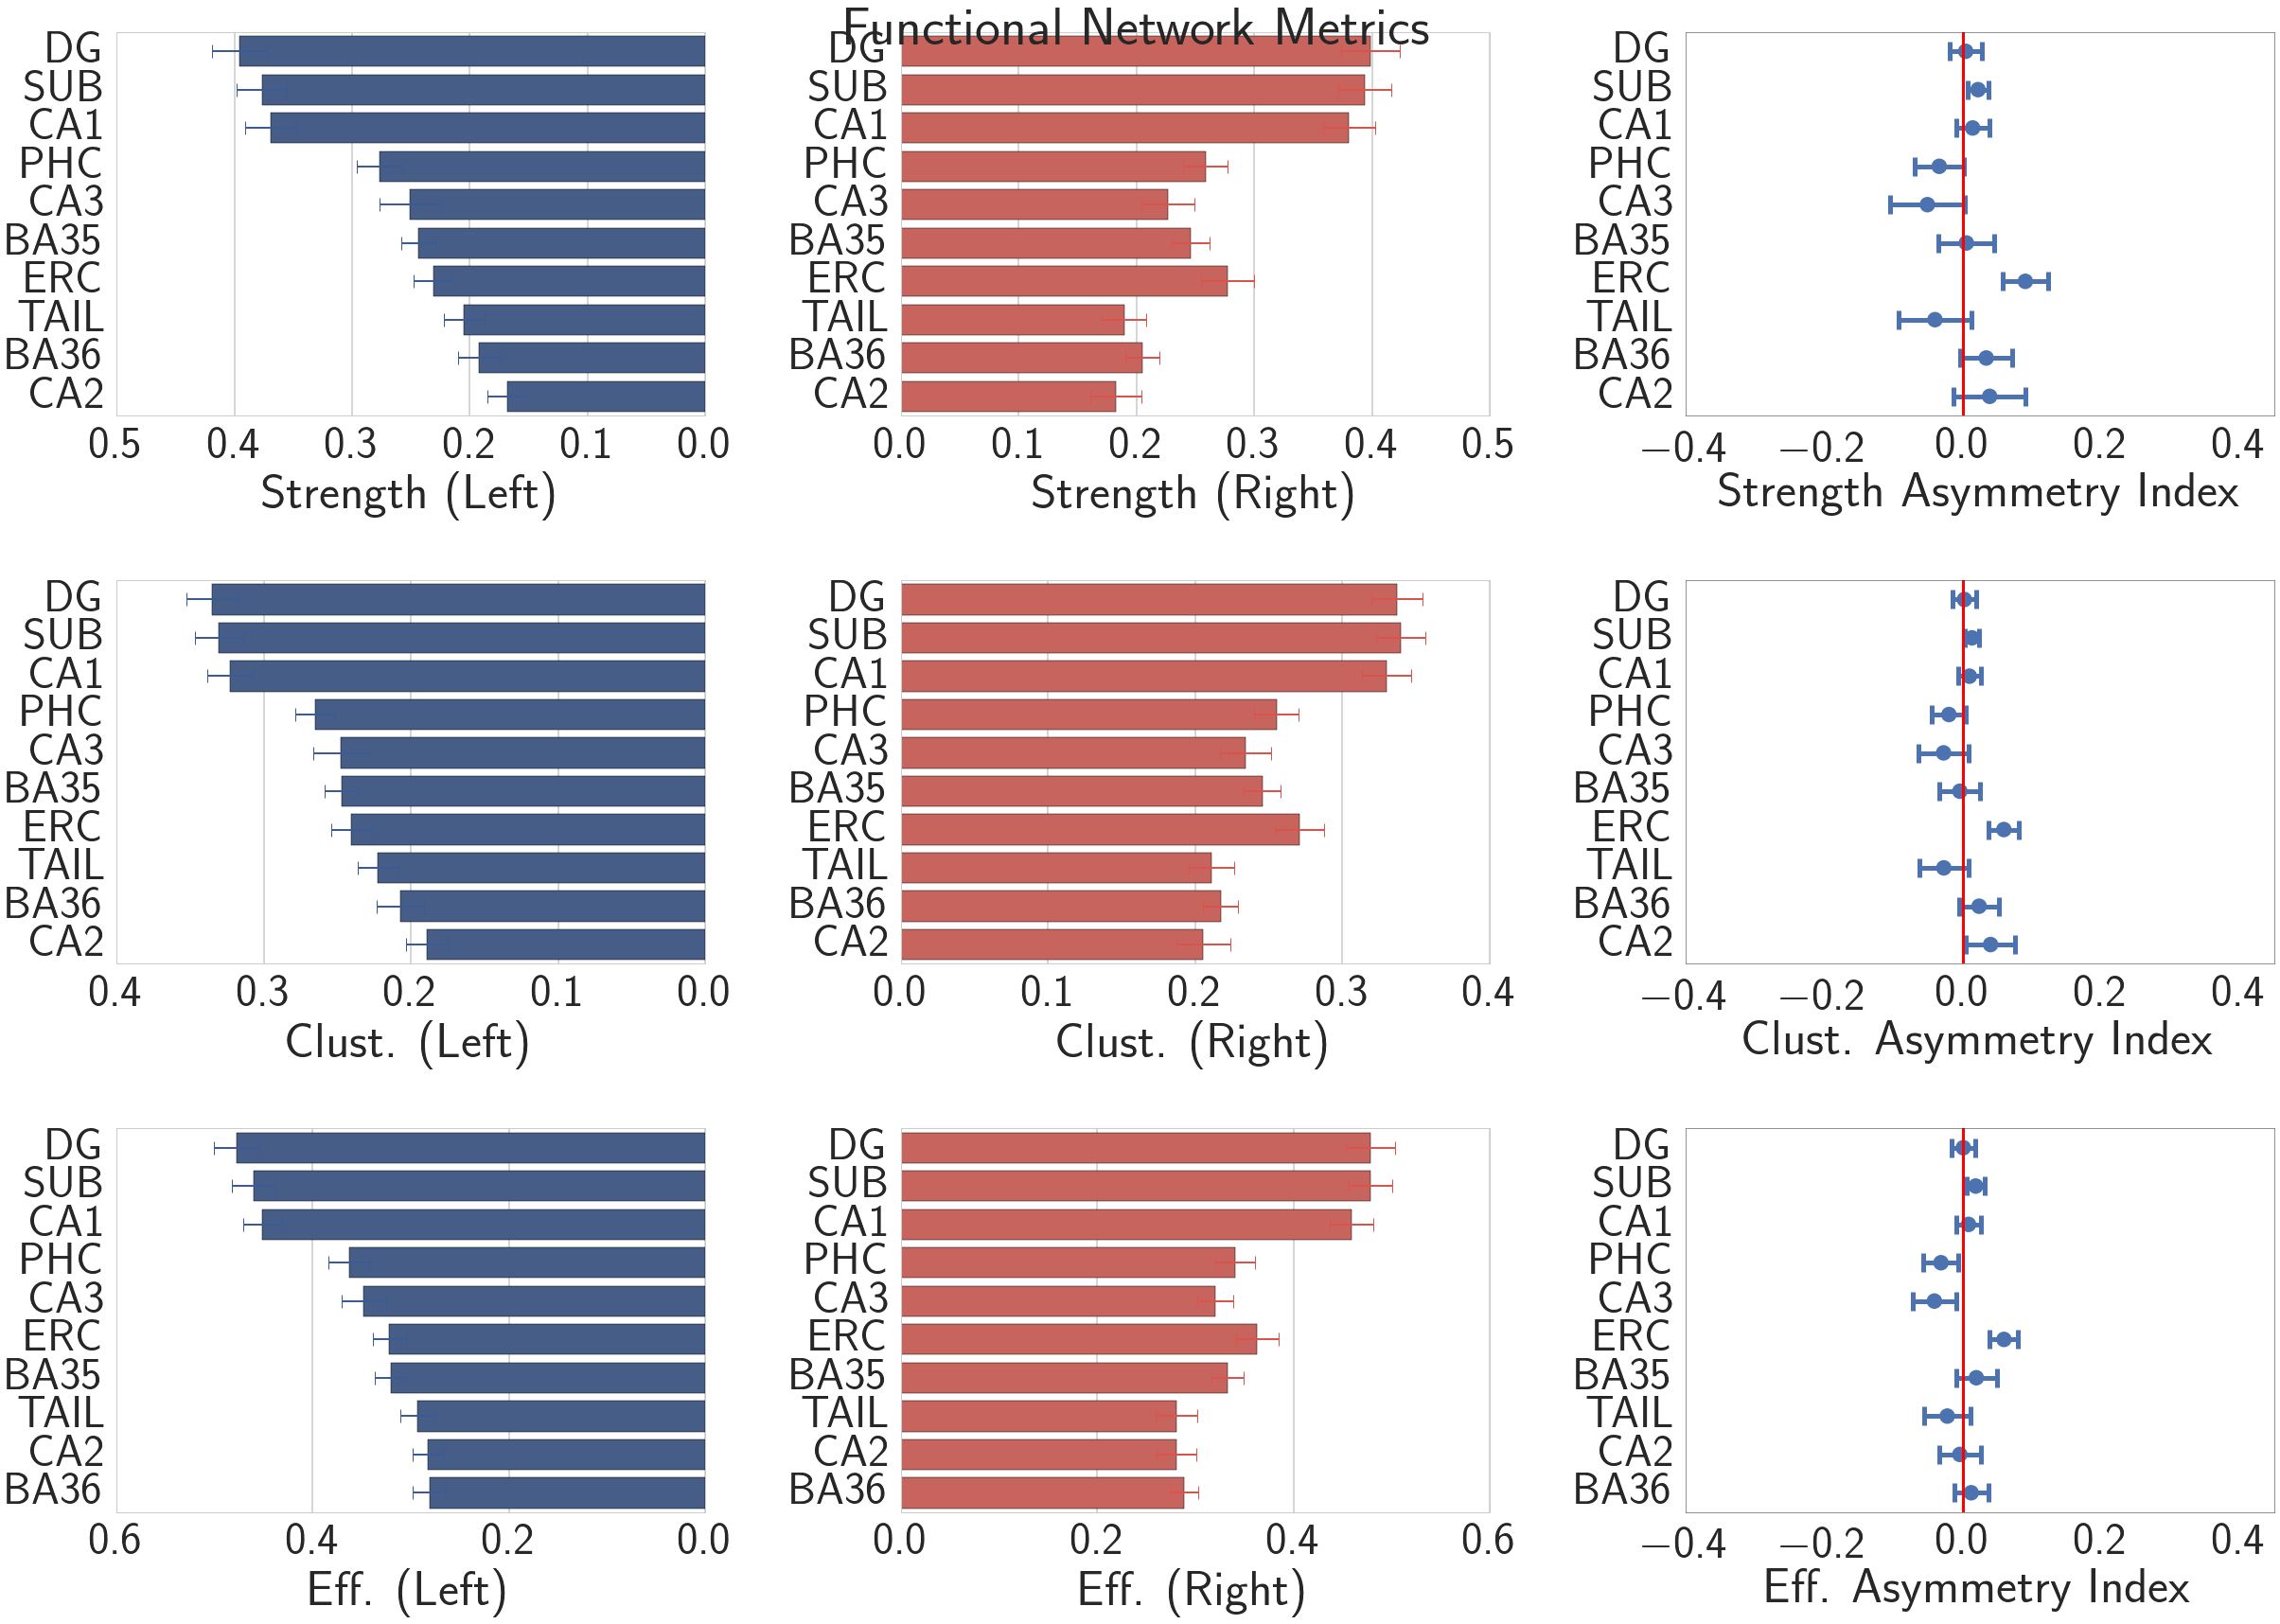

In [304]:
sb.set(context="poster", font_scale=3)
plt.figure(figsize=(35,25))
sb.set_style("whitegrid")
plt.suptitle("Functional Network Metrics")

# Left CS
left_strength_sortidx = np.argsort(np.mean(fleftCS,axis=0))[::-1]
left_sorted = fleftCS[:,left_strength_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_strength_sortidx]

plt.subplot(3, 3, 1)
plt.locator_params(nbins=5)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Strength (Left)')

#Right CS
right_sorted = frightCS[:,left_strength_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_strength_sortidx]

plt.subplot(3, 3, 2)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Strength (Right)')

CS_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 3)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=CS_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(CS_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(CS_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.45])
plt.xlabel('Strength Asymmetry Index')

## CC
# Left CC
left_CC_sortidx = np.argsort(np.mean(fleftCC,axis=0))[::-1]
left_sorted = fleftCC[:,left_CC_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_CC_sortidx]

plt.subplot(3, 3, 4)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Clust. (Left)')

# Right CC
right_sorted = frightCC[:,left_CC_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_CC_sortidx]

plt.subplot(3, 3, 5)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Clust. (Right)')

CC_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 6)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=CC_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(CC_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(CC_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.45])
plt.xlabel('Clust. Asymmetry Index')

# Left GE
left_GE_sortidx = np.argsort(np.mean(fleftLE,axis=0))[::-1]
left_sorted = fleftLE[:,left_GE_sortidx] 
left_labels=[MTlabelshalf[i] for i in left_GE_sortidx]

plt.subplot(3, 3, 7)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=left_sorted.transpose(),index=left_labels)
plt.errorbar(np.array(np.mean(left_sorted,axis=0)),  np.arange(N), xerr=np.array(np.std(left_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["denim blue"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["denim blue"],alpha=1,orient="h" )
plt.gca().invert_xaxis()
plt.xlabel('Eff. (Left)')

# Right GE
right_sorted = frightLE[:,left_GE_sortidx] 
right_labels=[MTlabelshalf[i] for i in left_GE_sortidx]

plt.subplot(3, 3, 8)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=right_sorted.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
plt.errorbar(np.array(np.mean(right_sorted,axis=0)),np.arange(N), xerr=np.array(np.std(right_sorted,axis=0)), linewidth=2, fmt="none",capsize=7,capthick=1,ecolor=sb.xkcd_rgb["pale red"]) 
ax = sb.barplot(data=df.transpose(),ci=None,color=sb.xkcd_rgb["pale red"],alpha=1,orient="h")
plt.xlabel('Eff. (Right)')

GE_asymm = (right_sorted - left_sorted)/(right_sorted + left_sorted)
plt.subplot(3, 3, 9)
plt.locator_params(nbins=5)
df = pd.DataFrame(data=GE_asymm.transpose(),index=right_labels)
sb.set_style("white",rc={'axes.linewidth': 0.5, 'axes.grid': False})
sb.set_style("whitegrid")
ax = sb.pointplot(data=df.transpose(),orient="h",ci=None,join=False)
plt.errorbar(np.array(np.mean(GE_asymm,axis=0)), np.arange(N), xerr=np.array(np.std(GE_asymm,axis=0)), linewidth=5, fmt="none",capsize=10,capthick=5)
ax.axvline(linewidth=3, color='r')
ax.set_xlim([-.4,.45])
plt.xlabel('Eff. Asymmetry Index')

plt.tight_layout()

We can also plot the left vs right metrics along with the pearson correlation line and the unity line to visualize network symmetry. This also allows us to easily spot network hubs:

### 6.1.3 Structural and Functional Network Asymmetry and Hubness Visualization

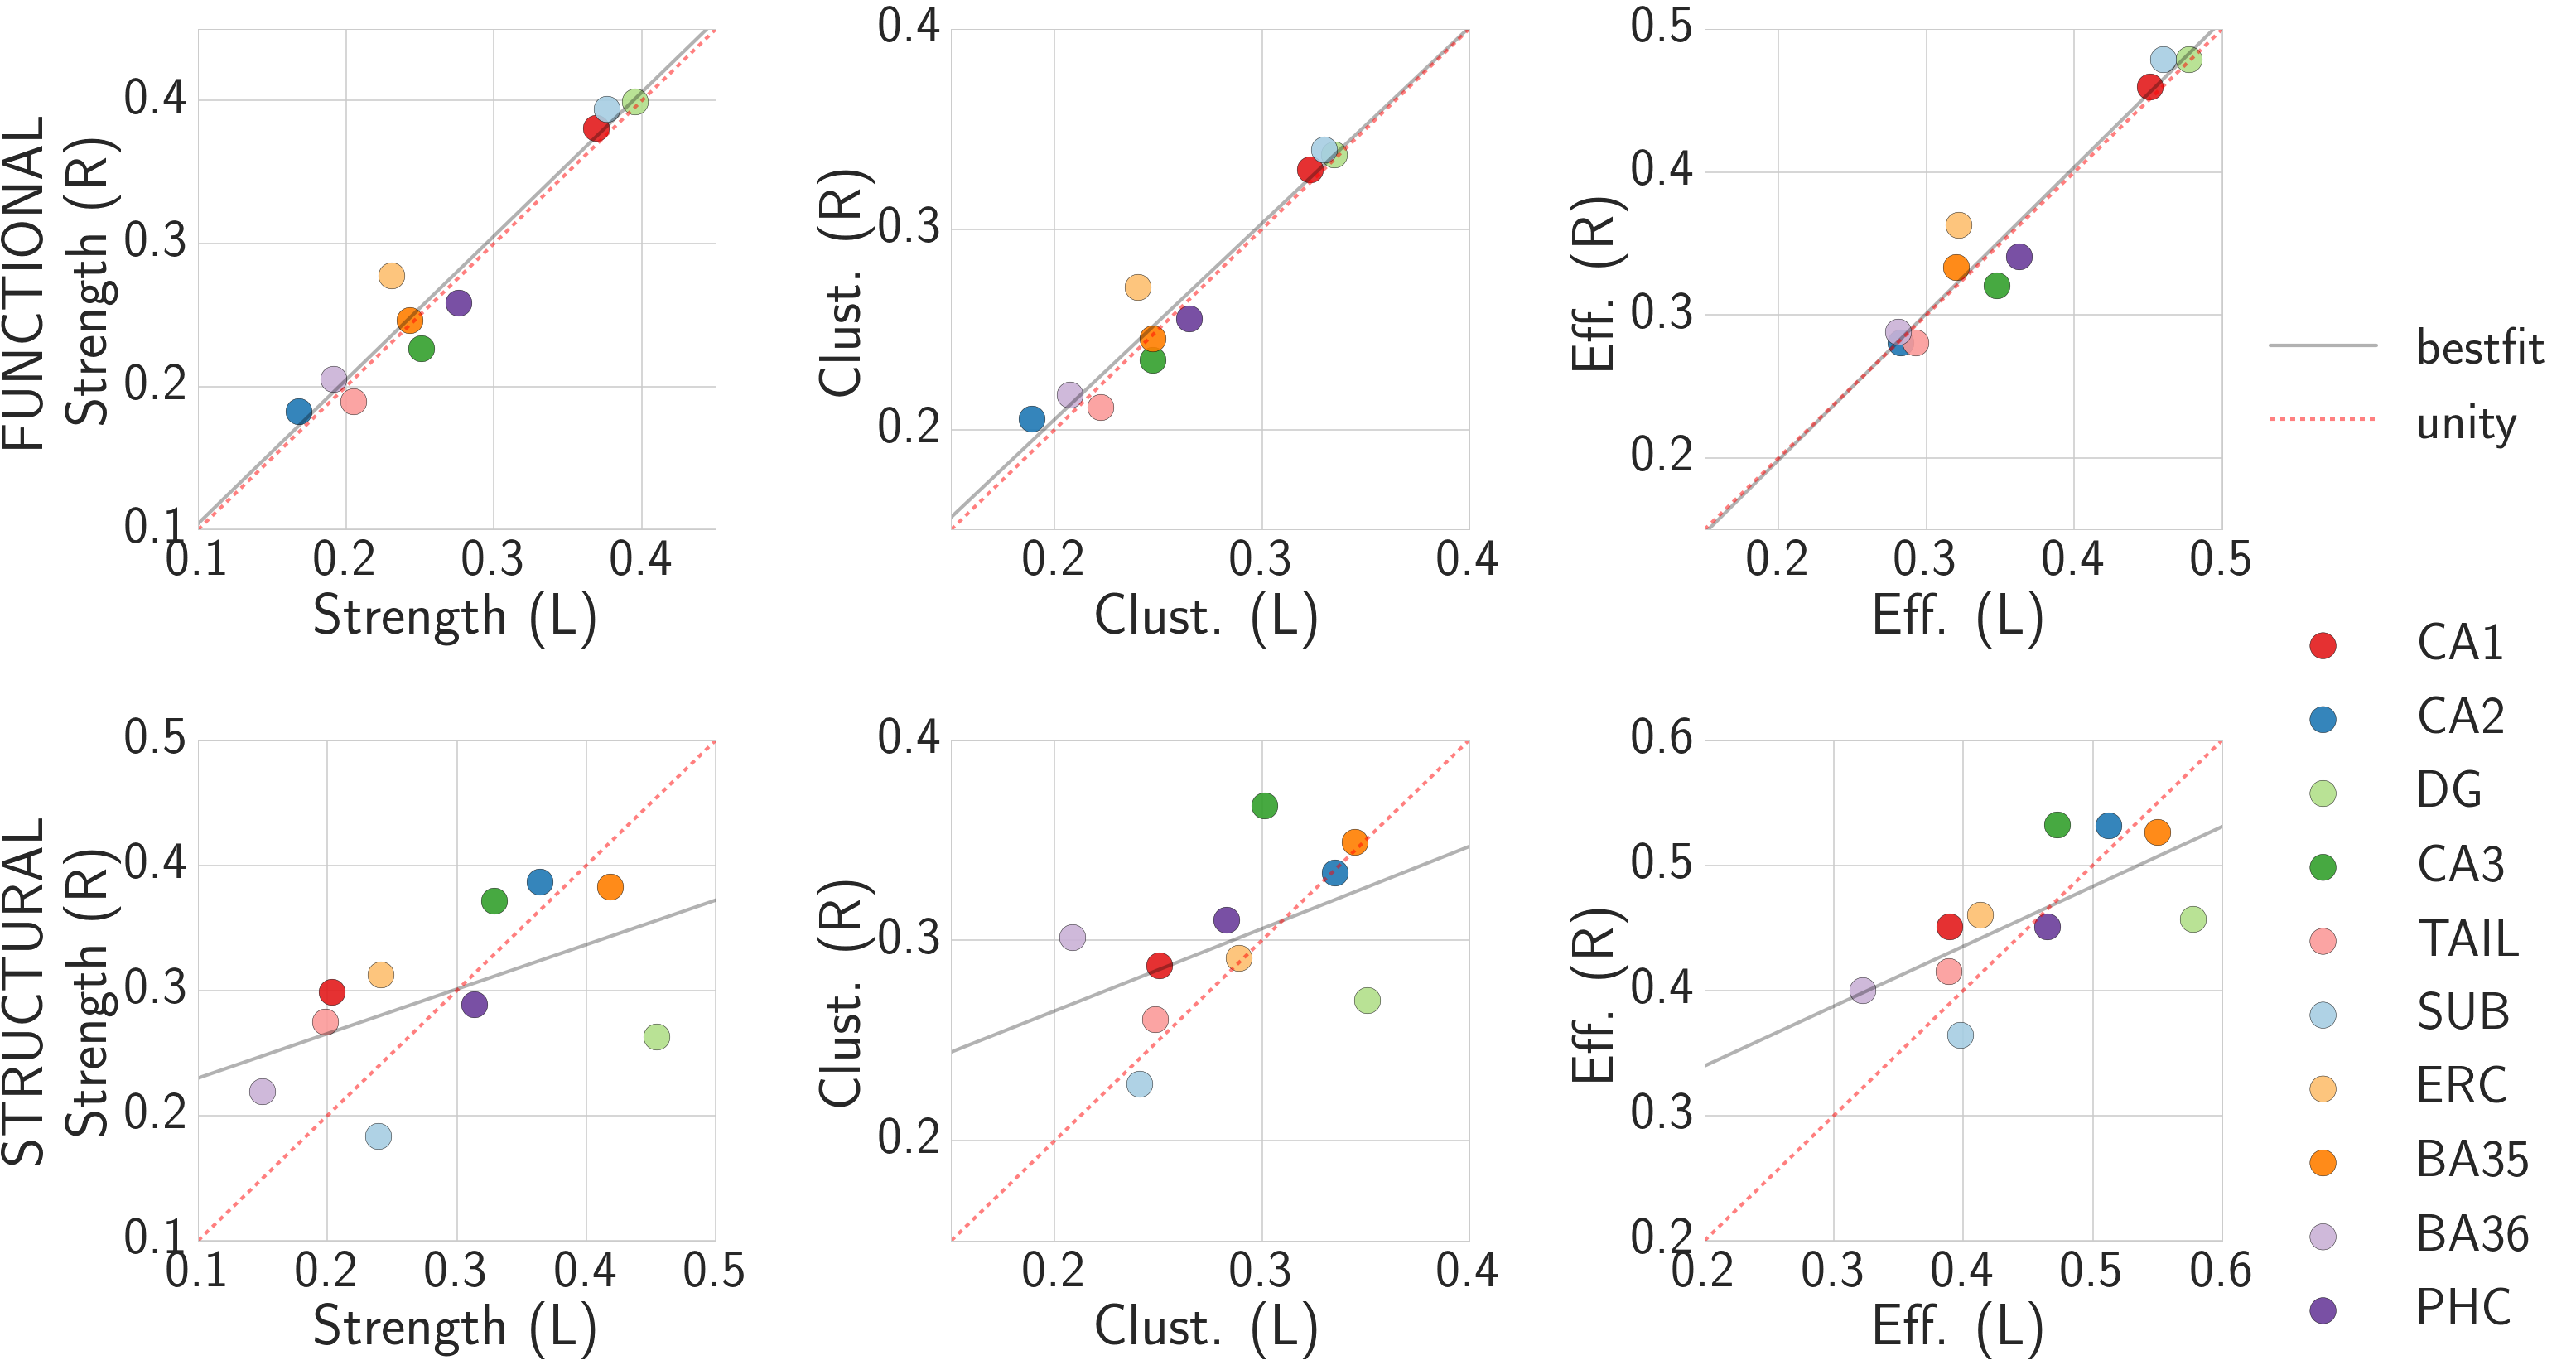

In [306]:
mycolorbrewer = ["#e31a1c","#1f78b4","#b2df8a","#33a02c","#fb9a99","#a6cee3","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a"]
sb.set(context="poster", font_scale=4)
sb.set_style("whitegrid")
plt.figure(figsize=(40,25))

#### Functional
plt.subplot(231)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.1,.45)
plt.ylim(0.1,.45)
g = sb.regplot(np.mean(fleftCS,axis=0),np.mean(frightCS,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(fleftCS,axis=0)[i],np.mean(frightCS,axis=0)[i],color=mycolor,
              s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Strength (L)")
plt.ylabel("FUNCTIONAL\n Strength (R)")
plt.locator_params(nbins=5)

plt.subplot(232)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.15,.4)
plt.ylim(0.15,.4)
g = sb.regplot(np.mean(fleftCC,axis=0),np.mean(frightCC,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(fleftCC,axis=0)[i],np.mean(frightCC,axis=0)[i],color=mycolor, s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Clust. (L)")
plt.ylabel("Clust. (R)")
plt.locator_params(nbins=5)

plt.subplot(233)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.15,.5)
plt.ylim(0.15,.5)
g = sb.regplot(np.mean(fleftLE,axis=0),np.mean(frightLE,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(fleftLE,axis=0)[i],np.mean(frightLE,axis=0)[i],color=mycolor, s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Eff. (L)")
plt.ylabel("Eff. (R)")
plt.locator_params(nbins=5)
plt.legend(loc='best', bbox_to_anchor=(1, 0.5),labels=["bestfit","unity","","","CA1", "CA2","DG","CA3","TAIL","SUB","ERC","BA35","BA36","PHC"])

#### STRUCTURAL
plt.subplot(234)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.1,.5)
plt.ylim(0.1,.5)
g = sb.regplot(np.mean(sleftCS,axis=0),np.mean(srightCS,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(sleftCS,axis=0)[i],np.mean(srightCS,axis=0)[i],color=mycolor,
              s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Strength (L)")
plt.ylabel("STRUCTURAL\n Strength (R)")
plt.locator_params(nbins=5)

plt.subplot(235)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.15,.4)
plt.ylim(0.15,.4)    
g = sb.regplot(np.mean(sleftCC,axis=0),np.mean(srightCC,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(sleftCC,axis=0)[i],np.mean(srightCC,axis=0)[i],color=mycolor, s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Clust. (L)")
plt.ylabel("Clust. (R)")
plt.locator_params(nbins=5)

plt.subplot(236)
colors = itertools.cycle(sb.color_palette(mycolorbrewer))
plt.xlim(0.2,.6)
plt.ylim(0.2,.6)  
g = sb.regplot(np.mean(sleftLE,axis=0),np.mean(srightLE,axis=0),marker='',ci=None, line_kws={'alpha':0.3,'color':'black'})
sb.regplot(np.array([0, 1, 2]),np.array([0, 1, 2]), marker='',ci=None,line_kws={'alpha':0.5,'color':'red', 'linestyle':'dashed'})
for i in range(N):
    mycolor = next(colors)  
    g.scatter(np.mean(sleftLE,axis=0)[i],np.mean(srightLE,axis=0)[i],color=mycolor, s=1000,alpha=0.9,edgecolors='k')
plt.xlabel("Eff. (L)")
plt.ylabel("Eff. (R)")
plt.locator_params(nbins=5)

plt.tight_layout()
plt.show()

We can also compute the overall network asymmetry index , $\nu$, for both functional and structural networks:

In [327]:
# Functional Asymmetry Index
AI_CS = np.mean(abs((np.mean(frightCS,axis=0) - np.mean(fleftCS,axis=0))/ (np.mean(frightCS,axis=0) + np.mean(fleftCS,axis=0)))) 
AI_CC= np.mean(abs((np.mean(frightCC,axis=0) - np.mean(fleftCC,axis=0))/ (np.mean(frightCC,axis=0) + np.mean(fleftCC,axis=0))))
AI_GE = np.mean(abs((np.mean(frightLE,axis=0) - np.mean(fleftLE,axis=0))/ (np.mean(frightLE,axis=0) + np.mean(fleftLE,axis=0))))
v_func = (AI_CS + AI_CC + AI_GE)/3.0

# Structural Asymmetry Index
AI_CS = np.mean(abs((np.mean(srightCS,axis=0) - np.mean(sleftCS,axis=0))/ (np.mean(srightCS,axis=0) + np.mean(sleftCS,axis=0)))) 
AI_CC= np.mean(abs((np.mean(srightCC,axis=0) - np.mean(sleftCC,axis=0))/ (np.mean(srightCC,axis=0) + np.mean(sleftCC,axis=0))))
AI_GE = np.mean(abs((np.mean(srightLE,axis=0) - np.mean(sleftLE,axis=0))/ (np.mean(srightLE,axis=0) + np.mean(sleftLE,axis=0))))
v_struct =(AI_CS + AI_CC + AI_GE)/3.0

print "v_func =" + str(v_func)
print "v_struct =" + str(v_struct)

v_func =0.0260824341844
v_struct =0.0790292452514


## 6.2: Community Detection / Modularity 

Here we compute the structural modular organization, with associated p value determining significance of the modular architecture. Note that the order of the modules may display slightly differently each time this is run.

STRUCTURAL MODULAR ORAGANIZATION, p=0.0002


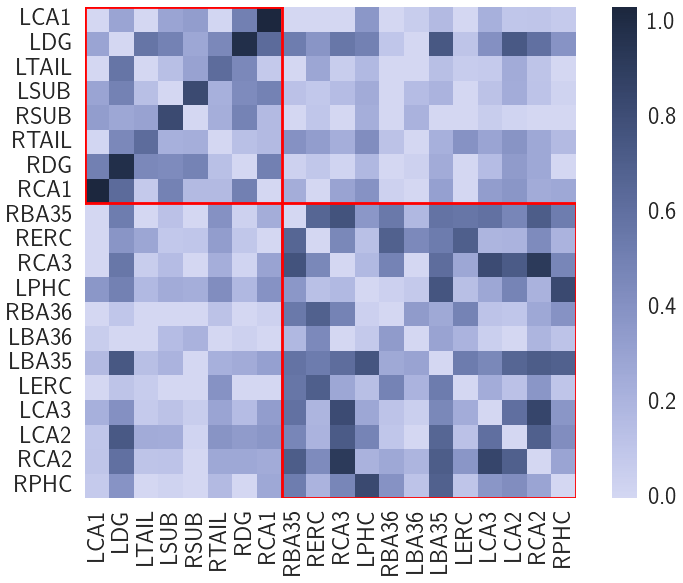

In [312]:
#show strucutral modules
sb.set(context="poster", font_scale=1.5)
S, Q = bct.community_louvain(structmat,1)
show_modules(structmat, S, MTlabels, mycmap)

# compute significance of structural modules using permutation testing
p = sig_mods(10000, structmat, Q, 1)

print "STRUCTURAL MODULAR ORAGANIZATION, " + "p=" + str(p)   

FUNCTIONAL MODULAR ORAGANIZATION, p=0.0269


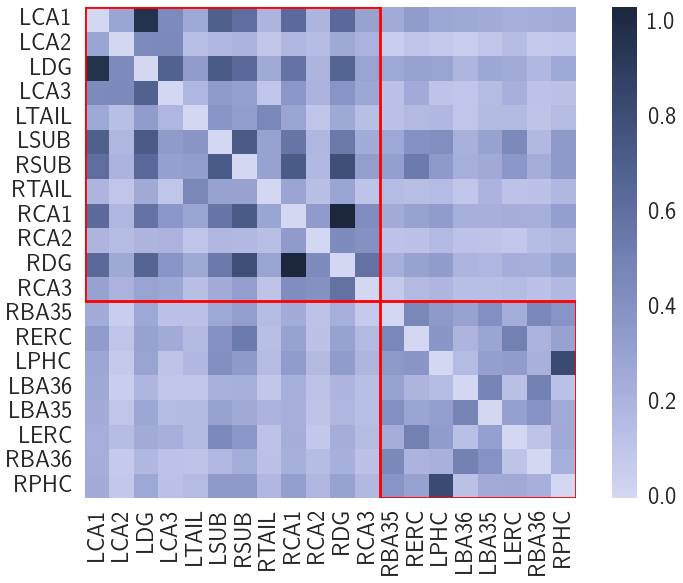

In [311]:
#show functional modules
sb.set(context="poster", font_scale=1.5)
S, Q = bct.community_louvain(funcmat,1)
show_modules(funcmat, S, MTlabels, mycmap)

# compute significance of functional modules using permutation testing
p = sig_mods(10000, funcmat, Q, 1)

print "FUNCTIONAL MODULAR ORAGANIZATION, " + "p=" + str(p)  

# 6.3 Structure-Function Relationship

Here we compute the relationship between structural and functional connectivity by correlating the edge weights in the group level structural and functional matrices:

r=0.253795135398, p=0.00052


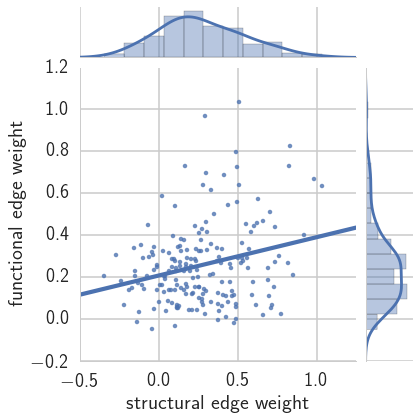

In [315]:
# generate vectors of edge strengths
struct_line = structmat_nonzeroed[np.triu_indices(2*N, 1)]
func_line = funcmats_nonzeroed_avg[np.triu_indices(2*N, 1)]

#permutation testing for significance of correlation
r = sp.stats.pearsonr(struct_line, func_line)[0]
iters = 100000
permfuncline = np.zeros((iters,190))
r_perm = np.zeros((iters,))
for i in range(iters):
    permfuncline[i,:] =  np.random.permutation(func_line)
    r_perm[i] = sp.stats.pearsonr(struct_line, permfuncline[i,:])[0]
p = (np.sum(r_perm > r) + np.sum(r_perm < -1*r)) / float(iters)

# plot results
sb.set(context="poster", font_scale=1.2)
sb.set_style("whitegrid")
g = sb.jointplot(struct_line,func_line,xlim=[-.5,1.25],ylim=[-0.2,1.2],kind="reg",stat_func=None)
g.set_axis_labels("structural edge weight", "functional edge weight")
g.ax_joint.collections[1].set_visible(False)
print "r=" + str(r) + ", p=" + str(p)

....And we're done!